In [1]:
import ast
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq

ETL del documento outputs_user_games.json

In [2]:
# Leer el archivo línea por línea y almacenar los resultados en una lista
filas = []

with open("../output_steam_games.json", "r", encoding="Latin-1") as archivo:
    for linea in archivo:
        try:
            objeto_json = json.loads(linea)
            filas.append(objeto_json)
        except json.JSONDecodeError:
            print(f"Error de formato JSON en la línea: {linea}")

#Convertir la lista de objetos JSON en un DataFrame
steam_games = pd.DataFrame(filas)

In [3]:
steam_games.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


Veremos lo valores nulos de cada columna

In [4]:
nulos_games = steam_games.isna().sum()
nulos_games

publisher       96362
genres          91593
app_name        88312
title           90360
url             88310
release_date    90377
tags            88473
reviews_url     88312
specs           88980
price           89687
early_access    88310
id              88312
developer       91609
dtype: int64

Eliminamos filas completas nulas

In [5]:
steam_games.dropna(how='all',inplace=True)

In [6]:
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32135 entries, 88310 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 3.4+ MB


Eliminamos columnas que no serían relevantes

In [7]:
steam_games.drop(columns=['publisher', 'title', 'url', 'early_access', 'reviews_url', 'specs'], inplace=True)

Vemos valores nulos en la columna id

In [8]:
steam_games[steam_games['id'].isnull()]

,genres,app_name,release_date,tags,price,id,developer
88384,NaN,NaN,NaN,NaN,19.99,NaN,NaN
119271,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",19.99,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


eliminamos los id nulos

In [9]:
steam_games.dropna(subset=['id'], inplace=True)

Se buscan duplicados y se eliminan

In [10]:
duplicados = steam_games['id'].value_counts() > 1
steam_games[steam_games['id'].isin(duplicados[duplicados].index)]

,genres,app_name,release_date,tags,price,id,developer
102204,[Action],Wolfenstein II: The New Colossus,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",59.99,612880,Machine Games
102883,[Action],Wolfenstein II: The New Colossus,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",59.99,612880,Machine Games


In [11]:
steam_games.drop_duplicates(subset='id',inplace=True,keep='first')

In [12]:
steam_games[steam_games['app_name'].isnull()]

,genres,app_name,release_date,tags,price,id,developer
90890,"[Action, Indie]",NaN,2014-08-26,"[Action, Indie]",NaN,317160,NaN


Existe un juego sin nombre, sin desarrolador y sin publicador, este se elimina

In [13]:
steam_games.dropna(subset='app_name',inplace=True)

Se resetean los indices

In [14]:
steam_games.reset_index(drop=True, inplace=True)

In [15]:
steam_games.head(3)

,genres,app_name,release_date,tags,price,id,developer
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,761140,Kotoshiro
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,643980,Secret Level SRL
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,670290,Poolians.com


Extraemos año

In [16]:
steam_games.isnull().sum()

genres          3282
app_name           0
release_date    2066
tags             162
price           1376
id                 0
developer       3297
dtype: int64

In [17]:
steam_games['año'] = steam_games['release_date'].str.extract(r'(\d{4})')

In [18]:
steam_games.drop(columns=['release_date'], inplace=True)

In [19]:
steam_games.head(4)

,genres,app_name,tags,price,id,developer,año
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",4.99,761140,Kotoshiro,2018
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,643980,Secret Level SRL,2018
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,670290,Poolians.com,2017
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",0.99,767400,彼岸领域,2017


In [20]:
steam_games.isnull().sum()

genres       3282
app_name        0
tags          162
price        1376
id              0
developer    3297
año          2167
dtype: int64

Verificamos si hay str en la columna precio

In [21]:
tipo_p = steam_games[steam_games['price'].apply(lambda x: isinstance(x, str))]
print(tipo_p['price'].value_counts())

price
Free                             905
Free to Play                     520
Free To Play                     462
Free Mod                           4
Free Demo                          3
Play Now                           2
Third-party                        2
Play for Free!                     2
Play WARMACHINE: Tactics Demo      1
Install Theme                      1
Install Now                        1
Free HITMAN™ Holiday Pack          1
Play the Demo                      1
Starting at $499.00                1
Starting at $449.00                1
Free to Try                        1
Free Movie                         1
Free to Use                        1
Name: count, dtype: int64


In [22]:
steam_games.loc[steam_games['price'].apply(lambda x: isinstance(x, str)), 'price'] = 0

In [23]:
steam_games.isnull().sum()

genres       3282
app_name        0
tags          162
price        1376
id              0
developer    3297
año          2167
dtype: int64

Nulos a cero

In [24]:
steam_games.fillna('0', inplace=True)

In [25]:
steam_games.isnull().sum()

genres       0
app_name     0
tags         0
price        0
id           0
developer    0
año          0
dtype: int64

Dummies para genres

In [26]:
steam_games['genres'] = steam_games['genres'].fillna('[]')
steam_games['genres'] = steam_games['genres'].apply(lambda x: ', '.join(x))

dummy = steam_games['genres'].str.get_dummies(', ')

steam_games = pd.concat([steam_games, dummy], axis = 1)

In [27]:
steam_games.head(4)

,genres,app_name,tags,price,id,developer,año,0,Accounting,Action,...,Photo Editing,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing
0,"Action, Casual, Indie, Simulation, Strategy",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",4.99,761140,Kotoshiro,2018,0,0,1,...,0,0,0,1,0,0,1,0,0,0
1,"Free to Play, Indie, RPG, Strategy",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...",0,643980,Secret Level SRL,2018,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,"Casual, Free to Play, Indie, Simulation, Sports",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...",0,670290,Poolians.com,2017,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,"Action, Adventure, Casual",弹炸人2222,"[Action, Adventure, Casual]",0.99,767400,彼岸领域,2017,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Cambio de dato para la columna año

In [28]:
steam_games['año'] = steam_games['año'].astype(int)

Id renombrado a item_id

In [29]:
steam_games =steam_games.rename(columns={'id' : 'item_id'})

In [30]:
steam_games.isnull().sum()

genres                       0
app_name                     0
tags                         0
price                        0
item_id                      0
developer                    0
año                          0
0                            0
Accounting                   0
Action                       0
Adventure                    0
Animation &amp; Modeling     0
Audio Production             0
Casual                       0
Design &amp; Illustration    0
Early Access                 0
Education                    0
Free to Play                 0
Indie                        0
Massively Multiplayer        0
Photo Editing                0
RPG                          0
Racing                       0
Simulation                   0
Software Training            0
Sports                       0
Strategy                     0
Utilities                    0
Video Production             0
Web Publishing               0
dtype: int64

In [31]:
steam_games = steam_games.to_csv('steam_games.csv', index=False)

In [32]:
steam_games = pd.read_csv('./steam_games.csv')

tabla = pa.Table.from_pandas(steam_games)

pq.write_table(tabla, 'steam_games.parquet')

ETL User_reviews.json

In [33]:
# Leer el archivo línea por línea y almacenar los resultados en una lista
filas = list()
with open("../australian_users_items.json", "r", encoding="Latin-1") as archivo:
    for linea in archivo.readlines():
        filas.append(ast.literal_eval(linea))

steam_items = pd.DataFrame(filas)
steam_items

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."
...,...,...,...,...,...
88305,76561198323066619,22,76561198323066619,http://steamcommunity.com/profiles/76561198323...,"[{'item_id': '413850', 'item_name': 'CS:GO Pla..."
88306,76561198326700687,177,76561198326700687,http://steamcommunity.com/profiles/76561198326...,"[{'item_id': '11020', 'item_name': 'TrackMania..."
88307,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,[]
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"[{'item_id': '304930', 'item_name': 'Unturned'..."


Nueva fila 

In [34]:
steam_items = steam_items.explode('items').reset_index()
steam_items = steam_items.drop(columns='index')
steam_items.head(5)

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '10', 'item_name': 'Counter-Strike..."
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '20', 'item_name': 'Team Fortress ..."
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '30', 'item_name': 'Day of Defeat'..."
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '40', 'item_name': 'Deathmatch Cla..."
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '50', 'item_name': 'Half-Life: Opp..."


In [35]:
steam_items = pd.concat([steam_items, pd.json_normalize(steam_items['items'])], axis=1)
steam_items.head(5)

,user_id,items_count,steam_id,user_url,items,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '10', 'item_name': 'Counter-Strike...",10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '20', 'item_name': 'Team Fortress ...",20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '30', 'item_name': 'Day of Defeat'...",30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '40', 'item_name': 'Deathmatch Cla...",40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '50', 'item_name': 'Half-Life: Opp...",50,Half-Life: Opposing Force,0.0,0.0


Vemos nulos

In [36]:
steam_items.isnull().sum()

user_id                 0
items_count             0
steam_id                0
user_url                0
items               16806
item_id             16806
item_name           16806
playtime_forever    16806
playtime_2weeks     16806
dtype: int64

Extraemos nulos

In [37]:
steam_items = steam_items.dropna()
steam_items.isnull().sum()

user_id             0
items_count         0
steam_id            0
user_url            0
items               0
item_id             0
item_name           0
playtime_forever    0
playtime_2weeks     0
dtype: int64

Vemos los tipos de datos que tenemos

In [38]:
steam_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5153209 entries, 0 to 5170013
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   items_count       int64  
 2   steam_id          object 
 3   user_url          object 
 4   items             object 
 5   item_id           object 
 6   item_name         object 
 7   playtime_forever  float64
 8   playtime_2weeks   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 393.2+ MB


In [39]:
len(steam_items)

5153209

Se van columnas que no usaremos

In [40]:
steam_items.drop(['user_url', 'items'], axis= 1, inplace= True)
steam_items.head(5)

,user_id,items_count,steam_id,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,50,Half-Life: Opposing Force,0.0,0.0


In [41]:
steam_items = steam_items.to_csv('steam_items.csv', index= False)
steam_items = pd.read_csv('steam_items.csv')

In [42]:
# Convierte la columna 'item_id' a cadenas
steam_items['item_id'] = steam_items['item_id'].astype(str)

# Elimina las comillas dobles
steam_items['item_id'] = steam_items['item_id'].str.replace('"', '')

# Convierte la columna 'item_id' a enteros
steam_items['item_id'] = steam_items['item_id'].astype(int)

In [43]:
print(steam_items['item_id'].dtypes)
steam_items['item_id'].head(5)

int32


0    10
1    20
2    30
3    40
4    50
Name: item_id, dtype: int32

In [44]:
items = pd.read_csv('steam_items.csv')

table = pa.Table.from_pandas(items)

pq.write_table(table, 'steam_items.parquet')

In [45]:
table = pq.read_table('steam_items.parquet')

items_parquet = table.to_pandas()

items_parquet.head(5)

,user_id,items_count,steam_id,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,50,Half-Life: Opposing Force,0.0,0.0


Procesamiento de user_reviews.json

In [46]:
filas = list()
with open("../australian_user_reviews.json", "r",encoding="Latin-1") as archivo:
    for linea in archivo.readlines():
        filas.append(ast.literal_eval(linea))

df_reviews = pd.DataFrame(filas)
df_reviews.head(5)

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


Explode para columna reviews

In [47]:
df_reviews = df_reviews.explode("reviews").reset_index()
df_reviews = df_reviews.drop(columns="index")
df_reviews = pd.concat([df_reviews, pd.json_normalize(df_reviews['reviews'])], axis=1)
df_reviews.head()

,user_id,user_url,reviews,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted November 5, 20...",,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted July 15, 2011....",,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted April 21, 2011...",,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted June 24, 2014....",,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted September 8, 2...",,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...


Vemos los nulos

In [48]:
nulos_reviews = df_reviews.isna().sum()
nulos_reviews

user_id         0
user_url        0
reviews        28
funny          28
posted         28
last_edited    28
item_id        28
helpful        28
recommend      28
review         28
dtype: int64

Tipo de datos

In [49]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      59333 non-null  object
 1   user_url     59333 non-null  object
 2   reviews      59305 non-null  object
 3   funny        59305 non-null  object
 4   posted       59305 non-null  object
 5   last_edited  59305 non-null  object
 6   item_id      59305 non-null  object
 7   helpful      59305 non-null  object
 8   recommend    59305 non-null  object
 9   review       59305 non-null  object
dtypes: object(10)
memory usage: 4.5+ MB


In [50]:
df_reviews['año'] = df_reviews['posted'].str.extract(r'(\d{4})')

In [51]:
df_reviews["año"].isna().value_counts()

año
False    49186
True     10147
Name: count, dtype: int64

In [52]:
df_reviews.isnull().sum()

user_id            0
user_url           0
reviews           28
funny             28
posted            28
last_edited       28
item_id           28
helpful           28
recommend         28
review            28
año            10147
dtype: int64

Sacamos valores faltantes de año

In [53]:
df_reviews = df_reviews.dropna(subset=['año'])

In [54]:
df_reviews.head(5)

,user_id,user_url,reviews,funny,posted,last_edited,item_id,helpful,recommend,review,año
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted November 5, 20...",,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,2011
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted July 15, 2011....",,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,2011
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted April 21, 2011...",,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,2011
3,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted June 24, 2014....",,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,2014
4,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted September 8, 2...",,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,2013


In [55]:
df_reviews.isnull().sum()

user_id        0
user_url       0
reviews        0
funny          0
posted         0
last_edited    0
item_id        0
helpful        0
recommend      0
review         0
año            0
dtype: int64

Analisis de sentimientos

In [56]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(review):
    
    if isinstance(review, str):
        sentiment = analyzer.polarity_scores(review)

        if sentiment['compound'] >= 0.05:
            return 2
        elif sentiment['compound'] <= -0.05:
            return 0
        else:
            return 1
    else:
        return 1
        
#Aplica la función de análisis de sentimiento a la columna 'reviews' si existe al menos una reseña

df_reviews['sentiment_analysis'] = df_reviews['review'].apply(analyze_sentiment)

In [57]:
df_reviews["sentiment_analysis"].value_counts()

sentiment_analysis
2    31657
1     9926
0     7603
Name: count, dtype: int64

<Axes: xlabel='sentiment_analysis', ylabel='Count'>

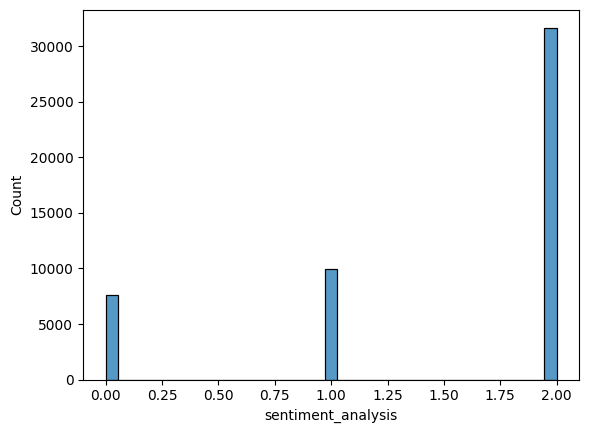

In [58]:
sns.histplot(data=df_reviews,x='sentiment_analysis')

Eliminamos columnas que no usaremos

In [59]:
df_reviews.drop(['reviews', 'user_url', 'funny', 'last_edited', 'posted', 'review'], axis=1, inplace=True)
df_reviews.head(4)
df_reviews.info

<bound method DataFrame.info of                  user_id item_id  \
0      76561197970982479    1250   
1      76561197970982479   22200   
2      76561197970982479   43110   
3                js41637  251610   
4                js41637  227300   
...                  ...     ...   
59280            wayfeng     730   
59283  76561198251004808  253980   
59293        72947282842     730   
59295          ApxLGhost     730   
59304  76561198267374962  369200   

                                               helpful recommend   año  \
0                                       No ratings yet      True  2011   
1                                       No ratings yet      True  2011   
2                                       No ratings yet      True  2011   
3      15 of 20 people (75%) found this review helpful      True  2014   
4         0 of 1 people (0%) found this review helpful      True  2013   
...                                                ...       ...   ...   
59280   1 of 1 pe

In [60]:
df_reviews.head(4)

,user_id,item_id,helpful,recommend,año,sentiment_analysis
0,76561197970982479,1250,No ratings yet,True,2011,2
1,76561197970982479,22200,No ratings yet,True,2011,2
2,76561197970982479,43110,No ratings yet,True,2011,2
3,js41637,251610,15 of 20 people (75%) found this review helpful,True,2014,2


Lo pasamos a csv

In [61]:
steam_reviews = df_reviews.to_csv('steam_reviews.csv', index=False)

In [62]:
steam_reviews = pd.read_csv('./steam_reviews.csv')

tabla = pa.Table.from_pandas(steam_reviews)

pq.write_table(tabla, 'steam_reviews.parquet')

In [63]:
# Leer el archivo Parquet en una tabla de PyArrow
table = pq.read_table('steam_reviews.parquet')

# Convertir la tabla de PyArrow a un DataFrame de pandas
reviews_parquet = table.to_pandas()

# Imprimir el DataFrame
reviews_parquet

,user_id,item_id,helpful,recommend,año,sentiment_analysis
0,76561197970982479,1250,No ratings yet,True,2011,2
1,76561197970982479,22200,No ratings yet,True,2011,2
2,76561197970982479,43110,No ratings yet,True,2011,2
3,js41637,251610,15 of 20 people (75%) found this review helpful,True,2014,2
4,js41637,227300,0 of 1 people (0%) found this review helpful,True,2013,2
...,...,...,...,...,...,...
49181,wayfeng,730,1 of 1 people (100%) found this review helpful,True,2015,1
49182,76561198251004808,253980,No ratings yet,True,2015,2
49183,72947282842,730,No ratings yet,True,2015,0
49184,ApxLGhost,730,No ratings yet,True,2015,2
